In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from rdkit import Chem
from collections import Counter
from tqdm import tqdm

In [85]:
df_confs = pd.read_csv('/localhome/cschiebroek/MDFPs/mdfptools/carl/data_curation/OPERA_Naef_Training_incl_num_confs_and_tabs.csv')
df_confs['smiles'] = df_confs['molblock'].apply(lambda x: Chem.MolToSmiles(Chem.MolFromMolBlock(x)))
df_confs_organic = df_confs[~df_confs['smiles'].str.contains('B|Si|As|Se')]
print(len(df_confs)-len(df_confs_organic), 'inorganic compounds (containing B, Si, As, or Se) removed')
molregno_to_ntabs = dict(zip(df_confs_organic['molregno'], df_confs_organic['ntabs']))

229 inorganic compounds (containing B, Si, As, or Se) removed


In [86]:
df_confs['smiles'].str.contains('I').sum()

36

In [52]:
molregno_to_molblock = dict(zip(df_confs_organic['molregno'], df_confs_organic['molblock']))


In [78]:
#load data again from pickles
import pickle
with open('/localhome/cschiebroek/MDFPs/mdfptools/carl/data_curation/splits/predictions/OPERA_Naef_XGBoost_PhysChem.pkl', 'rb') as f:
    data_xgboost_physchem = pickle.load(f)
pred_list_xgboost_physchem = data_xgboost_physchem['pred_list']
ys_list_xgboost_physchem = data_xgboost_physchem['ys_list']
molregnos_xgboost_physchem = data_xgboost_physchem['molregnos']
pred_list_xgboost_physchem_flat = [item for sublist in pred_list_xgboost_physchem for item in sublist]
ys_list_xgboost_physchem_flat = [item for sublist in ys_list_xgboost_physchem for item in sublist]
molregnos_xgboost_physchem_flat = [item for sublist in molregnos_xgboost_physchem for item in sublist]
df_results_xgboost_physchem = pd.DataFrame({'Pred_Physchem': pred_list_xgboost_physchem_flat, 'vp_log10_pa': ys_list_xgboost_physchem_flat, 'molregno': molregnos_xgboost_physchem_flat})
molregno_to_ntabs = dict(zip(df_confs_organic['molregno'], df_confs_organic['ntabs']))
df_results_xgboost_physchem = df_results_xgboost_physchem[df_results_xgboost_physchem['molregno'].isin(df_confs_organic['molregno'])]
df_results_xgboost_physchem['AE'] = abs(df_results_xgboost_physchem['Pred_Physchem'] - df_results_xgboost_physchem['vp_log10_pa'])
df_results_xgboost_physchem_avg = df_results_xgboost_physchem.groupby('molregno').mean()

In [79]:

with open('/localhome/cschiebroek/MDFPs/mdfptools/carl/data_curation/splits/predictions/OPERA_Naef_XGBoost_MDFP.pkl', 'rb') as f:
    data_xgboost_mdfp_plus = pickle.load(f)
pred_list_xgboost_mdfp_plus = data_xgboost_mdfp_plus['pred_list']
ys_list_xgboost_mdfp_plus = data_xgboost_mdfp_plus['ys_list']
molregnos_xgboost_mdfp_plus = data_xgboost_mdfp_plus['molregnos']
pred_list_xgboost_mdfp_plus_flat = [item for sublist in pred_list_xgboost_mdfp_plus for item in sublist]
ys_list_xgboost_mdfp_plus_flat = [item for sublist in ys_list_xgboost_mdfp_plus for item in sublist]
molregnos_xgboost_mdfp_plus_flat = [item for sublist in molregnos_xgboost_mdfp_plus for item in sublist]
df_results_xgboost_mdfp_plus = pd.DataFrame({'Pred_MDFP': pred_list_xgboost_mdfp_plus_flat, 'vp_log10_pa': ys_list_xgboost_mdfp_plus_flat, 'molregno': molregnos_xgboost_mdfp_plus_flat})
df_results_xgboost_mdfp_plus = df_results_xgboost_mdfp_plus[df_results_xgboost_mdfp_plus['molregno'].isin(df_confs_organic['molregno'])]
df_results_xgboost_mdfp_plus['AE'] = abs(df_results_xgboost_mdfp_plus['Pred_MDFP'] - df_results_xgboost_mdfp_plus['vp_log10_pa'])
df_results_xgboost_mdfp_plus_avg = df_results_xgboost_mdfp_plus.groupby('molregno').mean()

In [80]:
#combine the two dataframes on molregno, suffices mdfp and physchem
df_results = df_results_xgboost_physchem_avg.merge(df_results_xgboost_mdfp_plus_avg, on='molregno', suffixes=('_physchem', '_mdfp'))
#drop vp_log10_pa_mdfp, and change name of vp_log10_pa_physchem to vp_log10_pa
df_results.drop(columns=['vp_log10_pa_mdfp'], inplace=True)
df_results.rename(columns={'vp_log10_pa_physchem': 'vp_log10_pa'}, inplace=True)
df_results['ntabs'] = df_results.index.map(molregno_to_ntabs)
df_results['flexibility'] = pd.cut(df_results['ntabs'], bins=[0, 50, 99999, 100000000], labels=['low', 'medium', 'high'])
df_results['flexibility'].value_counts()

flexibility
low       1520
medium     591
high       113
Name: count, dtype: int64

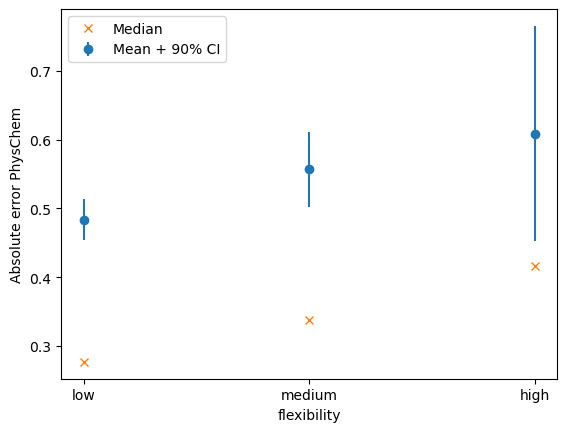

flexibility
low       0.276755
medium    0.337006
high      0.416706
Name: AE_physchem, dtype: float64
flexibility
low       1520
medium     591
high       113
Name: count, dtype: int64


In [81]:
#calculate mean and 95CI of AE PhysChem and AE MDFP per flexibility
physchem_means = df_results.groupby('flexibility')['AE_physchem'].mean()
physchem_ci = df_results.groupby('flexibility')['AE_physchem'].std() * 1.96 / df_results.groupby('flexibility')['AE_physchem'].count()**0.5
mdfp_means = df_results.groupby('flexibility')['AE_mdfp'].mean()
mdfp_ci = df_results.groupby('flexibility')['AE_mdfp'].std() * 1.96 / df_results.groupby('flexibility')['AE_mdfp'].count()**0.5
physchem_medians = df_results.groupby('flexibility')['AE_physchem'].median()
mdfp_medians = df_results.groupby('flexibility')['AE_mdfp'].median()
#plot
plt.figure()
x = np.arange(len(physchem_means))
plt.errorbar(x, physchem_means, yerr=physchem_ci, label='Mean + 90% CI',linestyle='',marker = 'o')
#add medians
plt.plot(x, physchem_medians, label='Median',linestyle='',marker = 'x')
plt.xticks(x, ['low', 'medium', 'high'])
plt.xlabel('flexibility')
plt.ylabel('Absolute error PhysChem')
plt.legend(loc = 'upper left')
plt.show()
#print medians for physchem
print(physchem_medians)
print(df_results['flexibility'].value_counts())

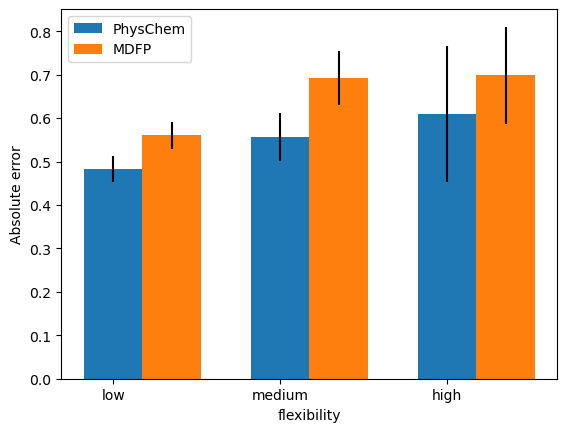

In [82]:
#and grouped barplot (AE mdfp/phsychem on y axis, x axis is flexibility)
plt.figure()
x = np.arange(len(physchem_means))
barWidth = 0.35
r1 = np.arange(len(physchem_means))
r2 = [x + barWidth for x in r1]
plt.bar(r1, physchem_means, yerr=physchem_ci, width = barWidth, label='PhysChem')
plt.bar(r2, mdfp_means, yerr=mdfp_ci, width = barWidth, label='MDFP')
plt.xticks(x, ['low', 'medium', 'high'])
plt.xlabel('flexibility')
plt.ylabel('Absolute error')
plt.legend(loc = 'upper left')
plt.show()

# Downsampling

/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/tmp/ipykernel_2371105/2441455851.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_downsampling_vp = df_results.groupby('vp_log10_pa_bin').apply(lambda x: x.sample(n=min(n_per_bin.values)))
/localhome/cschiebroek/.cond

Text(0, 0.5, 'Number of datapoints')

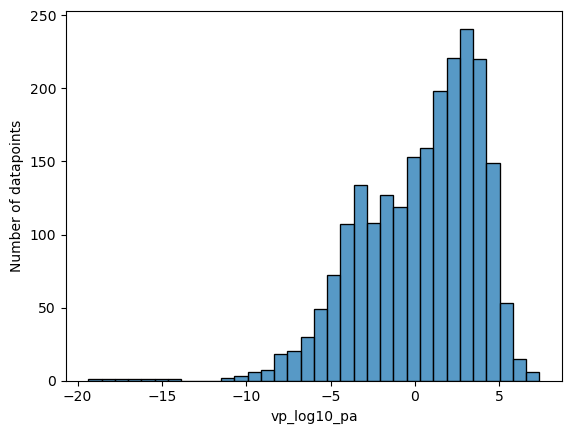

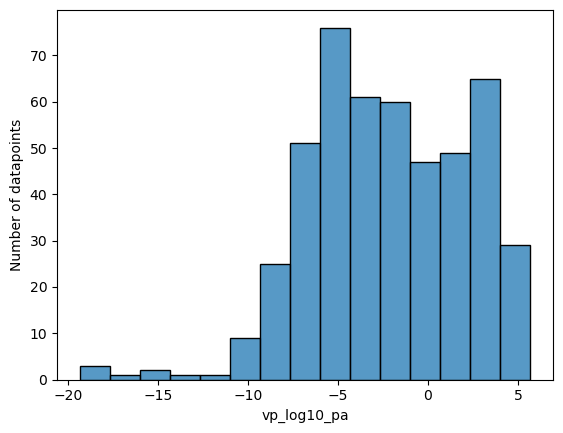

In [44]:
#barplot of vp_log1o_pa from df_confs
plt.figure()
sns.histplot(df_results['vp_log10_pa'])
plt.xlabel('vp_log10_pa')
plt.ylabel('Number of datapoints')
#now do downsampling, so same amount of datapoints in <-5, -5-0,>0
df_results['vp_log10_pa_bin'] = pd.cut(df_results['vp_log10_pa'], bins=[-20, -5, 0, 10])
n_per_bin = df_results['vp_log10_pa_bin'].value_counts().sort_index()
df_downsampling_vp = df_results.groupby('vp_log10_pa_bin').apply(lambda x: x.sample(n=min(n_per_bin.values)))
plt.figure()
sns.histplot(df_downsampling_vp['vp_log10_pa'])
plt.xlabel('vp_log10_pa')
plt.ylabel('Number of datapoints')

/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/tmp/ipykernel_2371105/2595273950.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_downsampling_flex = df_results.groupby('flexibility').apply(lambda x: x.sample(n=min(n_per_bin.values)))
/localhome/cschiebroek/.conda/

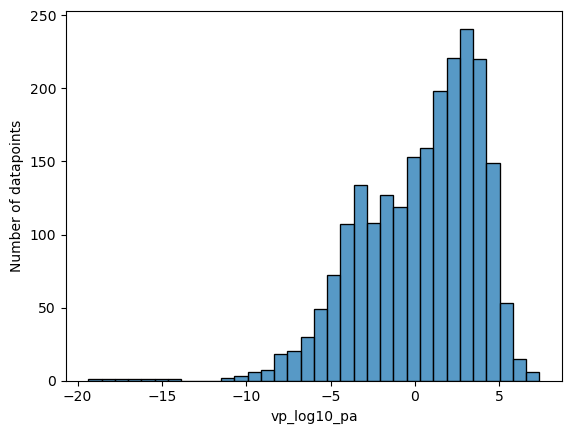

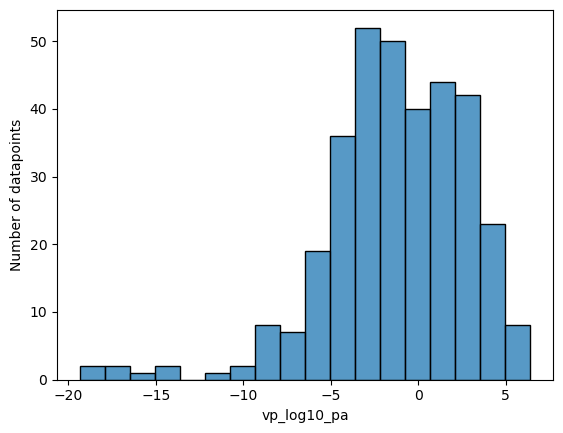

In [45]:
#downsampling based on flexibility
plt.figure()
sns.histplot(df_results['vp_log10_pa'])
plt.xlabel('vp_log10_pa')
plt.ylabel('Number of datapoints')
#now do downsampling, so same amount of datapoints in <-5, -5-0,>0
n_per_bin = df_results['flexibility'].value_counts().sort_index()
df_downsampling_flex = df_results.groupby('flexibility').apply(lambda x: x.sample(n=min(n_per_bin.values)))
plt.figure()
sns.histplot(df_downsampling_flex['vp_log10_pa'])
plt.xlabel('vp_log10_pa')
plt.ylabel('Number of datapoints')
df_downsampling_flex.drop(columns=['flexibility'], inplace=True) 


In [70]:
#first experiment: XGBoost PhysicalChem Descriptors
import xgboost as xgb
import pickle
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import RepeatedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
#disable future warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


def XGBOOST_random_splits(params, descriptors,train_dfs,val_dfs):
    pred_list,ys_list,molregnos = [],[],[]
    i = 0
    for df_train,df_val in zip(train_dfs,val_dfs):
        train_X = df_train[descriptors]
        train_y = df_train['vp_log10_pa']
        val_X = df_val[descriptors]
        val_y = df_val['vp_log10_pa']
        dtrain = xgb.DMatrix(train_X, label=train_y)
        dval = xgb.DMatrix(val_X, label=val_y)
        model = xgb.train(
            params,
            dtrain,
            num_boost_round=999,
            verbose_eval=False
        )
        preds = model.predict(dval)
        rmse = mean_squared_error(val_y, preds, squared=False)
        pred_list.append(preds)
        ys_list.append(val_y)
        molregnos.append(df_val.index.get_level_values(1))
        print(f"Split {i + 1}: RMSE = {rmse}")
        i += 1
    return pred_list, ys_list, molregnos
  

In [62]:
df_downsampling_flex_molregnos = df_downsampling_flex.index.get_level_values(1)

df_downsampling_flex_molregnos

Index([ 3007,  1009,  4212,  3611,  4029, 16748, 16992, 16130,  3628,   898,
       ...
        3071,  1010, 15915, 15772,  3209,  2673,   360,  2895,    41,  3276],
      dtype='int64', name='molregno', length=339)

In [65]:
from rdkit.Chem import Descriptors

df_downsampling_flex['molblocks'] = df_downsampling_flex.index.get_level_values(1).map(molregno_to_molblock)
df_downsampling_flex['ROMol'] = df_downsampling_flex['molblocks'].apply(lambda x: Chem.MolFromMolBlock(x))
df_downsampling_flex['descriptors'] = df_downsampling_flex['ROMol'].apply(Descriptors.CalcMolDescriptors)
df = pd.concat([df_downsampling_flex, pd.DataFrame(df_downsampling_flex['descriptors'].apply(lambda x: x if x is not None else {}).to_list(), index=df_downsampling_flex.index)], axis=1)

In [66]:
from sklearn.model_selection import train_test_split
df_train_list,df_val_list = [],[]
for i in range(10):
    df_train, df_val = train_test_split(df, test_size=0.2)
    df_train_list.append(df_train)
    df_val_list.append(df_val)

In [71]:
params = { #hyperparameters optimized by Working Wang
    'max_depth':5,
    'min_child_weight': 5,
    'eta':.3,
    'subsample': 1,
    'colsample_bytree': 1,
}
RDKit_feature_names = pd.read_pickle('/localhome/cschiebroek/MDFPs/mdfptools/carl/data/outputs/RDKit_2D_descriptors.pkl')
pred_list_xgboost_physchem, ys_list_xgboost_physchem, molregnos_xgboost_physchem = XGBOOST_random_splits(params, RDKit_feature_names, df_train_list, df_val_list)

Split 1: RMSE = 1.0981922582727577
Split 2: RMSE = 1.5535784054455761
Split 3: RMSE = 2.202054135527278
Split 4: RMSE = 1.1047111675125723
Split 5: RMSE = 1.0716066392831656
Split 6: RMSE = 1.4862381355726328
Split 7: RMSE = 1.3111290592012832
Split 8: RMSE = 1.0646577591800033
Split 9: RMSE = 1.2975810687826612
Split 10: RMSE = 1.3239508101665518


In [73]:
preds_flat = [item for sublist in pred_list_xgboost_physchem for item in sublist]
ys_flat = [item for sublist in ys_list_xgboost_physchem for item in sublist]
molregnos_flat = [item for sublist in molregnos_xgboost_physchem for item in sublist]
df_flex_downsampled = pd.DataFrame({'Pred_Physchem': preds_flat, 'vp_log10_pa': ys_flat, 'molregno': molregnos_flat})
#avg over molregnos
df_flex_downsampled_avg = df_flex_downsampled.groupby('molregno').mean()
df_flex_downsampled_avg['AE'] = abs(df_flex_downsampled_avg['Pred_Physchem'] - df_flex_downsampled_avg['vp_log10_pa'])
df_flex_downsampled_avg['ntabs'] = df_flex_downsampled_avg.index.map(molregno_to_ntabs)
df_flex_downsampled_avg['flexibility'] = pd.cut(df_flex_downsampled_avg['ntabs'], bins=[0, 50, 99999, 100000000], labels=['low', 'medium', 'high'])
df_flex_downsampled_avg['flexibility'].value_counts()

flexibility
medium    101
low       100
high       99
Name: count, dtype: int64

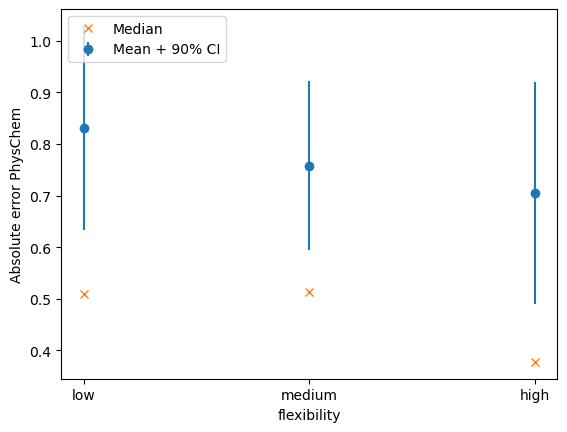

flexibility
low       0.509992
medium    0.513324
high      0.377374
Name: AE, dtype: float64
flexibility
medium    101
low       100
high       99
Name: count, dtype: int64


In [75]:
#calculate mean and 95CI of AE PhysChem and AE MDFP per flexibility
physchem_means = df_flex_downsampled_avg.groupby('flexibility')['AE'].mean()
physchem_ci = df_flex_downsampled_avg.groupby('flexibility')['AE'].std() * 1.96 / df_flex_downsampled_avg.groupby('flexibility')['AE'].count()**0.5
physchem_medians = df_flex_downsampled_avg.groupby('flexibility')['AE'].median()
#plot
plt.figure()
x = np.arange(len(physchem_means))
plt.errorbar(x, physchem_means, yerr=physchem_ci, label='Mean + 90% CI',linestyle='',marker = 'o')
#add medians
plt.plot(x, physchem_medians, label='Median',linestyle='',marker = 'x')
plt.xticks(x, ['low', 'medium', 'high'])
plt.xlabel('flexibility')
plt.ylabel('Absolute error PhysChem')
plt.legend(loc = 'upper left')
plt.show()
#print medians for physchem
print(physchem_medians)
print(df_flex_downsampled_avg['flexibility'].value_counts())